In [3]:
from cProfile import label
from pickletools import optimize
from random import sample
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

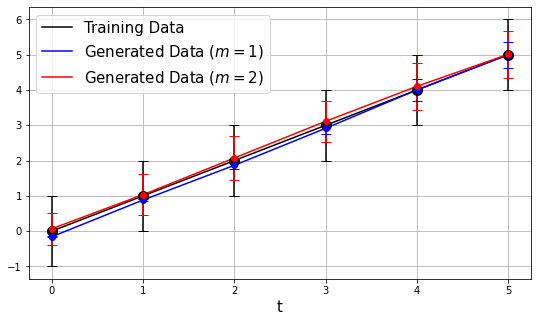

In [4]:
length = 6
place = "shuron/"
name = "result"

dim1_gene_av = torch.tensor([[-0.1582],
        [ 0.8824],
        [ 1.8662],
        [ 2.9149],
        [ 4.0037],
        [ 4.9979]]).reshape(-1)

dim1_gene_sg = torch.tensor([[0.0207],
        [0.0375],
        [0.0959],
        [0.1534],
        [0.3109],
        [0.3646]]).reshape(-1)

dim2_gene_av = torch.tensor([[0.0679],
        [1.0343],
        [2.0732],
        [3.1123],
        [4.1033],
        [5.0121]]).reshape(-1)
dim2_gene_sg = torch.tensor([[0.4514],
        [0.5739],
        [0.6117],
        [0.5777],
        [0.6727],
        [0.6644]]).reshape(-1)


training_av = torch.tensor([i * 1.0 for i in range(length)])
training_sg = torch.tensor([1.0 for i in range(length)])

FS = 15
fig = plt.figure(figsize=(9, 5))
# plt.title("Sin Curves")
plt.xlabel("t", fontsize=15)
# plt.ylabel("y", fontsize=FS)
plt.rcParams["font.size"] = FS
training_color = "black"
plt.errorbar(np.arange(0,length), training_av.detach().numpy(), yerr = training_sg.detach().numpy(), capsize=5, fmt='o', markersize=10, ecolor='black', markeredgecolor = "black", color='black')
plt.plot(np.arange(0,length), training_av.detach().numpy(),color='black', label="Training Data")
gene_color = "blue"
plt.errorbar(np.arange(0,length), dim1_gene_av.detach().numpy(), yerr = dim1_gene_sg.detach().numpy(), capsize=5, fmt='o', markersize=6, ecolor=gene_color, markeredgecolor = gene_color, color=gene_color)
plt.plot(np.arange(0,length), dim1_gene_av.detach().numpy(),color=gene_color, label="Generated Data " + r"($m=1$)")
gene_color = "red"
plt.errorbar(np.arange(0,length), dim2_gene_av.detach().numpy(), yerr = dim2_gene_sg.detach().numpy(), capsize=5, fmt='o', markersize=6, ecolor=gene_color, markeredgecolor = gene_color, color=gene_color)
plt.plot(np.arange(0,length), dim2_gene_av.detach().numpy(),color=gene_color, label="Generated Data "+ r"($m=2$)")
# plt.xticks([0,1,2,3], [0,1,2,3], size=15)
# plt.yticks([0, 3, 6, 9], [0, 3, 6, 9],size=15)
plt.grid()
plt.legend()
plt.savefig(place + name +  "_result.pdf")

# 実験1-1

In [8]:
name = "1_1"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss.npy")
wloss_hist = np.load("Array/" + name + "_wloss.npy")
mmd_hist = np.load("Array/" + name + "_mmd.npy")
# hyper = np.load("Array/" + name + "_hyper.npy")
test_data = np.load("Array/" + name + "_test.npy")
xreconstructed = np.load("Array/" + name + "_xreconstructed.npy")
zreconstructed = np.load("Array/" + name + "_zreconstructed.npy")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q.npy")
zgenerated = np.load("Array/" + name + "_zgenerated.npy")
xgenerated = np.load("Array/" + name + "_xgenerated.npy")

損失関数の描画

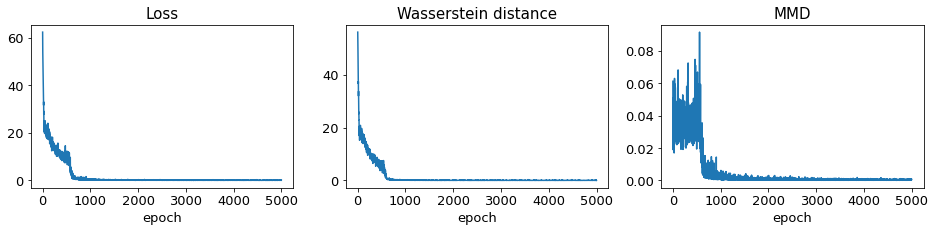

In [13]:
plt.figure(figsize=(16,3))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [15]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(4,7))
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$")
        plt.ylabel(r"$x$")
        y_lim = [-1.5, 6.5]
        plt.ylim(y_lim)
        # plt.title(r"$x(t)$ (" + type_of_data +", sample:" + str(xdata.shape[0]) + ")")
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, name, "xtrain", place)
plot_data(xreconstructed, name, "xrecon", place)
plot_data(xgenerated, name, "xgene",place)

AttributeError: 'memoryview' object has no attribute 'cpu'

空間$\mathcal{Z}$上での描画

In [16]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(5,7))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()


plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

AttributeError: 'memoryview' object has no attribute 'numpy'

# 実験1-2

In [ ]:
name = "1_2"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(4,7))
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$")
        plt.ylabel(r"$x$")
        y_lim = [-1.5, 6.5]
        plt.ylim(y_lim)
        # plt.title(r"$x(t)$ (" + type_of_data +", sample:" + str(xdata.shape[0]) + ")")
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(5,7))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

# 実験2-1

In [ ]:
name = "2_1"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        # x_lim = [-3.0, 3.0] 
        # y_lim = [-3.0, 3.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$x_1$", size=16)
        # plt.ylim(x_lim)
    
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size=16)
        plt.ylabel(r"$x_2$", size=16)
        # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + "_trajectories.pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(5,7))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

    

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

# 実験2-2

In [ ]:
name = "2_2"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        # x_lim = [-3.0, 3.0] 
        # y_lim = [-3.0, 3.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$x_1$", size=16)
        # plt.ylim(x_lim)
    
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size=16)
        plt.ylabel(r"$x_2$", size=16)
        # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + "_trajectories.pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 2:
        plt.figure(figsize=((12,5)))
        plt.subplot(121)
        # 時系列データを二次元平面上の軌道としてプロットする
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$z_2$", size= 16)
        # x_lim = [-1.0, 1.0] 
        # y_lim = [-1.0, 1.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # plt.title("Trajectories of " + type_of_data)

        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_1$", size= 16)
        # plt.ylim(x_lim)
        # plt.title(r"$z_1(t)$ and $z_2(t)$ of " + type_of_data)
        
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z_2$", size= 16)
        # plt.ylim(y_lim)
        # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

# 実験2-3

In [ ]:
name = "2_3"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        # x_lim = [-3.0, 3.0] 
        # y_lim = [-3.0, 3.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$x_1$", size=16)
        # plt.ylim(x_lim)
    
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size=16)
        plt.ylabel(r"$x_2$", size=16)
        # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + "_trajectories.pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 3:
        # 時系列データを三次元平面上の軌道としてプロットする
        fig = plt.figure(figsize=(12,7.5))
        ax = fig.add_subplot(121, projection='3d')
        ax.set_xlabel(r"$z_1$", labelpad=10, size= 15)
        ax.set_ylabel(r"$z_2$", labelpad=10, size= 15)
        ax.set_zlabel(r"$z_3$", labelpad=10, size= 15)
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], zdata[i,:,2], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        # plt.ylabel(r"$z_2$", size= 16)
        # plt.zlabel(r"$z_3$")
        
        # 時系列データの第一成分をプロット
        plt.subplot(322)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_1$", size= 16)
        
        # 時系列データの第二成分をプロット
        plt.subplot(324)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_2$", size= 16)
        # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")

        # 時系列データの第三成分をプロット
        plt.subplot(326)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,2], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z_3$", size= 16)
        # plt.title(r"$z_3(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

# 実験3-1

In [ ]:
name = "3_1"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        # x_lim = [-3.0, 3.0] 
        # y_lim = [-3.0, 3.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$x_1$", size=16)
        # plt.ylim(x_lim)
    
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size=16)
        plt.ylabel(r"$x_2$", size=16)
        # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + "_trajectories.pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 1:
        # 時系列データの第一成分をプロット
        plt.figure(figsize=(5,7))
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z$", size= 16)
        # y_lim = 3.0
        # plt.ylim(1.8, 3.2)
        # plt.title(r"$z(t)$ of" + type_of_data)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

# 実験3-2

In [ ]:
name = "3_2"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        # x_lim = [-3.0, 3.0] 
        # y_lim = [-3.0, 3.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$x_1$", size=16)
        # plt.ylim(x_lim)
    
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size=16)
        plt.ylabel(r"$x_2$", size=16)
        # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + "_trajectories.pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 2:
        plt.figure(figsize=((12,5)))
        plt.subplot(121)
        # 時系列データを二次元平面上の軌道としてプロットする
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$z_2$", size= 16)
        # x_lim = [-1.0, 1.0] 
        # y_lim = [-1.0, 1.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # plt.title("Trajectories of " + type_of_data)

        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_1$", size= 16)
        # plt.ylim(x_lim)
        # plt.title(r"$z_1(t)$ and $z_2(t)$ of " + type_of_data)
        
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z_2$", size= 16)
        # plt.ylim(y_lim)
        # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)

# 実験3-3

In [ ]:
name = "3_3"
place = "shuron/"

loss_hist = np.load("Array/" + name + "_loss")
wloss_hist = np.load("Array/" + name + "_wloss")
mmd_hist = np.load("Array/" + name + "_mmd")
hyper = np.load("Array/" + name + "_hyper")
test_data = np.load("Array/" + name + "_test")
xreconstructed = np.load("Array/" + name + "_xreconstructed")
zreconstructed = np.load("Array/" + name + "_zreconstructed")
zreconstructed_q = np.load("Array/" + name + "_zreconstructed_q")
zgenerated = np.load("Array/" + name + "_zgenerated")
xgenerated = np.load("Array/" + name + "_xgenerated")

損失関数の描画

In [ ]:
plt.figure(figsize=(16,7))
FontSize = 13
plt.rcParams["font.size"] = FontSize
plt.subplot(131)
plt.plot(loss_hist)
plt.title("Loss",size= 15)
plt.xlabel("epoch")
# Wasserstein distance
plt.subplot(132)
plt.plot(wloss_hist)
plt.title("Wasserstein distance", size= 15)
plt.xlabel("epoch")
# MMD
plt.subplot(133)
plt.plot(mmd_hist)
plt.title("MMD", size= 15)
plt.xlabel("epoch")
plt.savefig(place + name + "_loss.pdf")
plt.show()
plt.close()

空間$\mathcal{X}$上の描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_data(xdata, type_of_data="?", saveName = "NO", place= "NO"):
    xdata = xdata.data.cpu().numpy()
    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if xdata.shape[-1] == 2:
        # 時系列データを二次元平面上の軌道としてプロットする
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        for i in range(5):
            plt.plot(xdata[i,:,0],xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$x_1$", size=16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        plt.ylabel(r"$x_2$", size=16)
        # x_lim = [-3.0, 3.0] 
        # y_lim = [-3.0, 3.0]
        # plt.xlim(x_lim)
        # plt.ylim(y_lim)
    
        # 時系列データの第一成分をプロット
        plt.subplot(222)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$x_1$", size=16)
        # plt.ylim(x_lim)
    
        # 時系列データの第二成分をプロット
        plt.subplot(224)
        for i in range(xdata.shape[0]):
            plt.plot(xdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size=16)
        plt.ylabel(r"$x_2$", size=16)
        # plt.ylim(y_lim)
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig( place +type_of_data + "_" + saveName + "_trajectories.pdf")
        plt.show()
        plt.close()

plot_data(test_data, "Traininig", name, place)
plot_data(xreconstructed, "Reconstructed", name, place)
plot_data(xgenerated, "Generated", name, place)

空間$\mathcal{Z}$上での描画

In [ ]:
cmap = plt.get_cmap("hsv")
def plot_zdata(zdata, type_of_data="?", saveName="NO", place="NO"):
    zdata = zdata.data.cpu().numpy()

    FontSize = 13
    plt.rcParams["font.size"] = FontSize
    if zdata.shape[-1] == 3:
        # 時系列データを三次元平面上の軌道としてプロットする
        fig = plt.figure(figsize=(12,7.5))
        ax = fig.add_subplot(121, projection='3d')
        ax.set_xlabel(r"$z_1$", labelpad=10, size= 15)
        ax.set_ylabel(r"$z_2$", labelpad=10, size= 15)
        ax.set_zlabel(r"$z_3$", labelpad=10, size= 15)
        for i in range(5):
            plt.plot(zdata[i,:,0],zdata[i,:,1], zdata[i,:,2], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$z_1$", size= 16) # TODO: labelなどの数式の表記は後でtexを使うように書き換える.ここだけではなく他も．
        # plt.ylabel(r"$z_2$", size= 16)
        # plt.zlabel(r"$z_3$")
        
        # 時系列データの第一成分をプロット
        plt.subplot(322)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,0], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_1$", size= 16)
        
        # 時系列データの第二成分をプロット
        plt.subplot(324)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,1], marker='o', markersize = 4)
        plt.grid()
        # plt.xlabel(r"$t$")
        plt.ylabel(r"$z_2$", size= 16)
        # plt.title(r"$z_2(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")

        # 時系列データの第三成分をプロット
        plt.subplot(326)
        for i in range(zdata.shape[0]):
            plt.plot(zdata[i,:,2], marker='o', markersize = 4)
        plt.grid()
        plt.xlabel(r"$t$", size= 16)
        plt.ylabel(r"$z_3$", size= 16)
        # plt.title(r"$z_3(t)$ (" + type_of_data +", sample:" + str(zdata.shape[0]) + ")")
        plt.tight_layout()
        if saveName != "NO":
            plt.savefig(place + type_of_data + "_" + saveName + ".pdf")
        plt.show()
        plt.close()

plot_zdata(zreconstructed_q, "latent_reconstruction_inference_net", name, place)
plot_zdata(zreconstructed, "latent_reconstruction_generation_net", name, place)
plot_zdata(zgenerated, "latent_generated", name, place)